# Monte Carlo Simulation of Win Probability in Fantasy Football (ESPN, Standard)
**Author:** Luke Hirshberg

This notebook simulates fantasy matchup outcomes via Monte Carlo sampling of player weekly score distributions, including **injury uncertainty**. It has **synthetic demo dataset** so I could run it immediately before scraping actual data from ESPN.

**Sections**
1. Setup & Utils  
2. Synthetic Demo Data  
3. Load Data 
4. Build Player Distributions (μ, σ, injury p)  
5. Monte Carlo Simulation (10k trials)  
6. Convergence & Sensitivity Analyses  
7. Lineup Decision Experiments  
8. Poster Exports
9. Actual ESPN Data
10. Load ESPN Data
11. Player Search

In [38]:
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
%matplotlib inline

# Keep plots simple (matplotlib, no styles/colors)
DATA_DIR = './data'
RAW_DIR  = f'{DATA_DIR}/raw'
PROC_DIR = f'{DATA_DIR}/processed'
FIG_DIR  = './figures'

for d in [DATA_DIR, RAW_DIR, PROC_DIR, FIG_DIR]:
    os.makedirs(d, exist_ok=True)

def peek(df, n=5, title=None):
    print(title or "Preview")
    print(df.head(n))

print("Folders ready:", DATA_DIR, RAW_DIR, PROC_DIR, FIG_DIR)

Folders ready: ./data ./data/raw ./data/processed ./figures


In [39]:
rng = np.random.default_rng(0)
players = pd.DataFrame({
    'player_id'  : [f'P{i:02d}' for i in range(1, 21)],
    'player_name': [f'Player {i:02d}' for i in range(1, 21)],
    'position'   : (['QB','RB','RB','WR','WR','TE','FLEX','K','DST','BN']*2),
    'team'       : ['TeamA']*10 + ['TeamB']*10,
})
players['mu']       = rng.normal(12, 4, len(players)).clip(6, 30)   # mean weekly points
players['sigma']    = rng.normal(5,  2, len(players)).clip(2, 12)   # weekly variability
players['injury_p'] = rng.uniform(0.03, 0.10, len(players))         # weekly injury probability

players.to_csv(f'{PROC_DIR}/players_synth.csv', index=False)
peek(players, title="Synthetic player baselines (μ, σ, injury p)")

Synthetic player baselines (μ, σ, injury p)
  player_id player_name position   team         mu     sigma  injury_p
0       P01   Player 01       QB  TeamA  12.502921  4.742931  0.070007
1       P02   Player 02       RB  TeamA  11.471581  7.732927  0.052531
2       P03   Player 03       RB  TeamA  14.561691  3.669611  0.071601
3       P04   Player 04       WR  TeamA  12.419600  5.703020  0.053654
4       P05   Player 05       WR  TeamA   9.857323  6.806940  0.057413


In [40]:
# These will be replaced with ESPN CSV's when I get them:
# hist   = pd.read_csv(f'{RAW_DIR}/espn_weekly_points.csv')   # columns: player_name, week, points
# roster = pd.read_csv(f'{RAW_DIR}/espn_roster_matchup.csv')  # columns: player_name, position, team

synth_path = f'{PROC_DIR}/players_synth.csv'
if os.path.exists(synth_path):
    players_df = pd.read_csv(synth_path)
else:
    raise FileNotFoundError("Provide ESPN CSVs in ./data/raw or run the synthetic cell above.")

peek(players_df, title="Players (loaded)")
print(players_df.columns.tolist())

Players (loaded)
  player_id player_name position   team         mu     sigma  injury_p
0       P01   Player 01       QB  TeamA  12.502921  4.742931  0.070007
1       P02   Player 02       RB  TeamA  11.471581  7.732927  0.052531
2       P03   Player 03       RB  TeamA  14.561691  3.669611  0.071601
3       P04   Player 04       WR  TeamA  12.419600  5.703020  0.053654
4       P05   Player 05       WR  TeamA   9.857323  6.806940  0.057413
['player_id', 'player_name', 'position', 'team', 'mu', 'sigma', 'injury_p']


In [41]:
def simulate_player_points(mu, sigma, p_injury, rng):
    # injury first (Bernoulli)
    if rng.random() < p_injury:
        return 0.0
    # healthy draw (Normal), clip at 0
    return float(max(0.0, rng.normal(mu, sigma)))

def simulate_team_score(players_team_df, n_trials=10_000, seed=42):
    rng = np.random.default_rng(seed)
    totals = np.zeros(n_trials, dtype=float)
    plist = players_team_df[['player_name','mu','sigma','injury_p']].to_dict('records')
    for t in range(n_trials):
        s = 0.0
        for p in plist:
            s += simulate_player_points(p['mu'], p['sigma'], p['injury_p'], rng)
        totals[t] = s
    return totals

# Two teams from the table (TeamA vs TeamB)
teamA = players_df[players_df['team']=='TeamA'].copy()
teamB = players_df[players_df['team']=='TeamB'].copy()

peek(teamA, title="TeamA baseline")
peek(teamB, title="TeamB baseline")

TeamA baseline
  player_id player_name position   team         mu     sigma  injury_p
0       P01   Player 01       QB  TeamA  12.502921  4.742931  0.070007
1       P02   Player 02       RB  TeamA  11.471581  7.732927  0.052531
2       P03   Player 03       RB  TeamA  14.561691  3.669611  0.071601
3       P04   Player 04       WR  TeamA  12.419600  5.703020  0.053654
4       P05   Player 05       WR  TeamA   9.857323  6.806940  0.057413
TeamB baseline
   player_id player_name position   team         mu     sigma  injury_p
10       P11   Player 11       QB  TeamB   9.506902  2.980764  0.085097
11       P12   Player 12       RB  TeamB  12.165304  4.581649  0.046756
12       P13   Player 13       RB  TeamB   6.000000  4.681550  0.091354
13       P14   Player 14       WR  TeamB  11.124833  6.081691  0.034100
14       P15   Player 15       WR  TeamB   7.016356  5.429318  0.053528


Win probability (TeamA): 0.743
Win probability (TeamB): 0.257


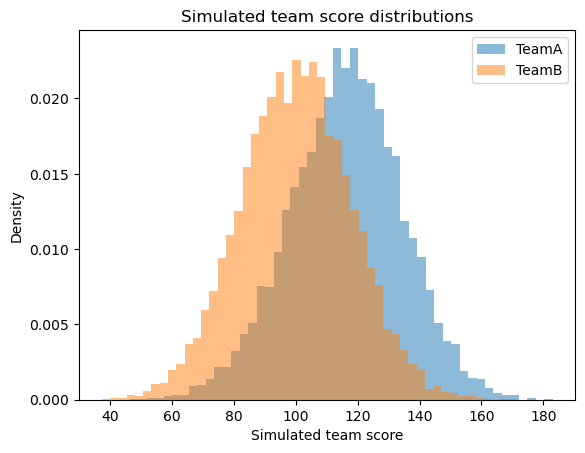

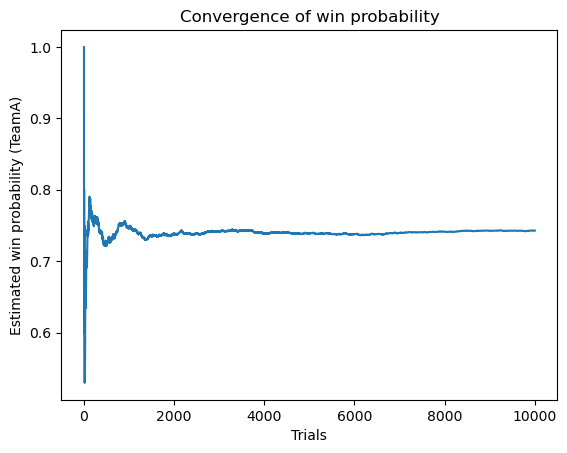

In [42]:
N_TRIALS = 10_000
A_scores = simulate_team_score(teamA, n_trials=N_TRIALS, seed=123)
B_scores = simulate_team_score(teamB, n_trials=N_TRIALS, seed=456)

win_prob_A = float(np.mean(A_scores > B_scores))
win_prob_B = 1.0 - win_prob_A

print(f"Win probability (TeamA): {win_prob_A:.3f}")
print(f"Win probability (TeamB): {win_prob_B:.3f}")

# Histogram of team scores
plt.figure()
plt.hist(A_scores, bins=50, density=True, alpha=0.5, label='TeamA')
plt.hist(B_scores, bins=50, density=True, alpha=0.5, label='TeamB')
plt.xlabel('Simulated team score'); plt.ylabel('Density'); plt.title('Simulated team score distributions'); plt.legend()
plt.show()

# Convergence of estimated win probability
est, wins = [], 0
for i in range(N_TRIALS):
    if A_scores[i] > B_scores[i]:
        wins += 1
    est.append(wins / (i+1))

plt.figure()
plt.plot(np.arange(1, N_TRIALS+1), est)
plt.xlabel('Trials'); plt.ylabel('Estimated win probability (TeamA)'); plt.title('Convergence of win probability')
plt.show()

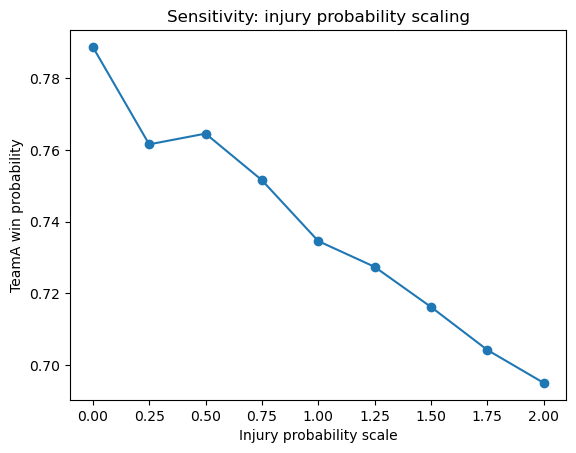

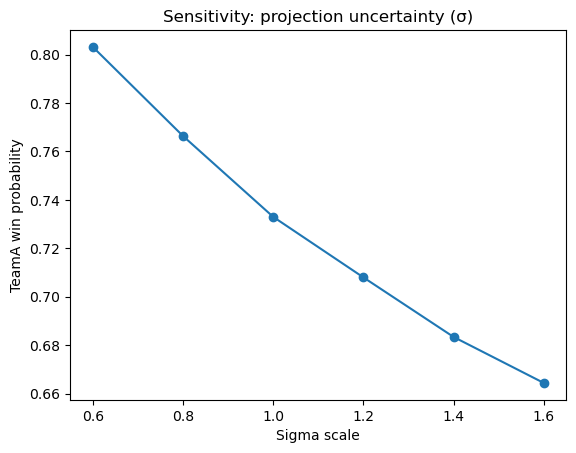

In [43]:
# Injury probability scaling
def with_injury_scale(df, scale):
    out = df.copy()
    out['injury_p'] = (out['injury_p'] * scale).clip(0.0, 0.8)
    return out

scales = np.linspace(0.0, 2.0, 9)  # 0% to 200%
wp_injury = []
for s in scales:
    A_mod = with_injury_scale(teamA, s)
    B_mod = with_injury_scale(teamB, s)
    A_s = simulate_team_score(A_mod, n_trials=5000, seed=789)
    B_s = simulate_team_score(B_mod, n_trials=5000, seed=1011)
    wp_injury.append(np.mean(A_s > B_s))

plt.figure()
plt.plot(scales, wp_injury, marker='o')
plt.xlabel('Injury probability scale'); plt.ylabel('TeamA win probability'); plt.title('Sensitivity: injury probability scaling')
plt.show()

# σ (projection uncertainty) scaling
def with_sigma_scale(df, scale):
    out = df.copy()
    out['sigma'] = (out['sigma'] * scale).clip(0.1, None)
    return out

sig_scales = np.linspace(0.6, 1.6, 6)
wp_sigma = []
for s in sig_scales:
    A_mod = with_sigma_scale(teamA, s)
    B_mod = with_sigma_scale(teamB, s)
    A_s = simulate_team_score(A_mod, n_trials=5000, seed=222)
    B_s = simulate_team_score(B_mod, n_trials=5000, seed=333)
    wp_sigma.append(np.mean(A_s > B_s))

plt.figure()
plt.plot(sig_scales, wp_sigma, marker='o')
plt.xlabel('Sigma scale'); plt.ylabel('TeamA win probability'); plt.title('Sensitivity: projection uncertainty (σ)')
plt.show()

In [44]:
def swap_player(team_df, old_name, new_name, new_mu, new_sigma, new_injp):
    df = team_df.copy()
    idx = df.index[df['player_name'] == old_name]
    if len(idx) == 0:
        raise ValueError(f"Player {old_name} not found.")
    i = idx[0]
    df.loc[i, 'player_name'] = new_name
    df.loc[i, 'mu'] = new_mu
    df.loc[i, 'sigma'] = new_sigma
    df.loc[i, 'injury_p'] = new_injp
    return df

# Example: tweak TeamA’s FLEX
altA = swap_player(teamA,
                   old_name='Player 07',
                   new_name='Bench Flex',
                   new_mu=10.0, new_sigma=6.0, new_injp=0.05)

A_s_base = simulate_team_score(teamA, n_trials=8000, seed=44)
B_s_base = simulate_team_score(teamB, n_trials=8000, seed=55)
base_wp = np.mean(A_s_base > B_s_base)

A_s_alt  = simulate_team_score(altA,  n_trials=8000, seed=66)
B_s_alt  = simulate_team_score(teamB,  n_trials=8000, seed=77)
alt_wp  = np.mean(A_s_alt > B_s_alt)

print(f"Win probability (base lineup):        {base_wp:.3f}")
print(f"Win probability (alternative lineup): {alt_wp:.3f}")
print(f"Δ win probability (alt - base):       {alt_wp - base_wp:+.3f}")

Win probability (base lineup):        0.735
Win probability (alternative lineup): 0.634
Δ win probability (alt - base):       -0.101


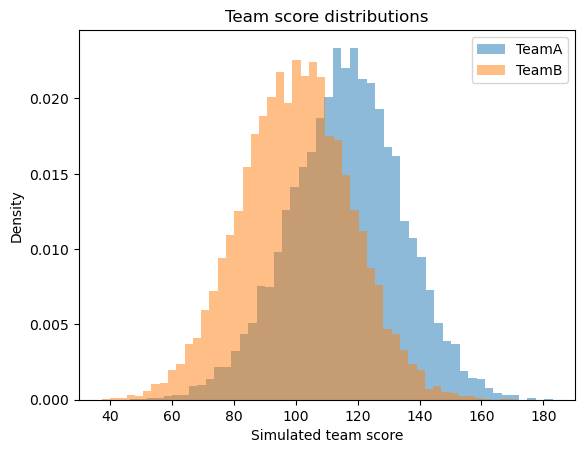

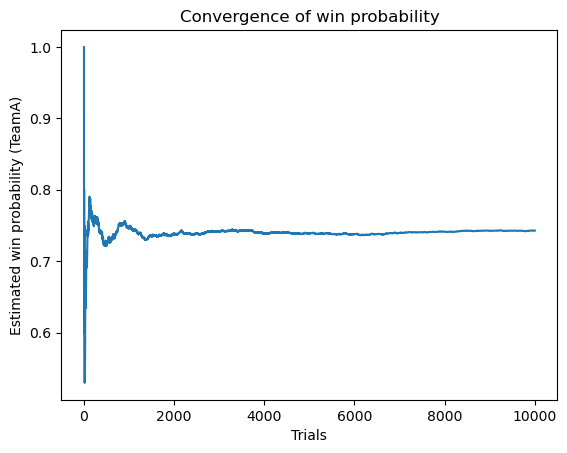

Saved figures → ./figures
Saved summary  → ./data/processed/summary_metrics.csv


In [45]:
os.makedirs(FIG_DIR, exist_ok=True)

def save_hist(fig_path, A_scores, B_scores):
    plt.figure()
    plt.hist(A_scores, bins=50, density=True, alpha=0.5, label='TeamA')
    plt.hist(B_scores, bins=50, density=True, alpha=0.5, label='TeamB')
    plt.xlabel('Simulated team score'); plt.ylabel('Density'); plt.title('Team score distributions'); plt.legend()
    plt.savefig(fig_path, dpi=200, bbox_inches='tight'); plt.show()

def save_convergence(fig_path, A_scores, B_scores):
    wins, est = 0, []
    for i in range(len(A_scores)):
        if A_scores[i] > B_scores[i]:
            wins += 1
        est.append(wins/(i+1))
    plt.figure()
    plt.plot(np.arange(1, len(A_scores)+1), est)
    plt.xlabel('Trials'); plt.ylabel('Estimated win probability (TeamA)'); plt.title('Convergence of win probability')
    plt.savefig(fig_path, dpi=200, bbox_inches='tight'); plt.show()

save_hist(f'{FIG_DIR}/poster_scores_hist.png', A_scores, B_scores)
save_convergence(f'{FIG_DIR}/poster_convergence.png', A_scores, B_scores)

summary = pd.DataFrame({
    'metric': ['win_prob_A','win_prob_B','A_mean','B_mean','A_std','B_std'],
    'value' : [float(np.mean(A_scores > B_scores)),
               float(np.mean(B_scores > A_scores)),
               float(np.mean(A_scores)),
               float(np.mean(B_scores)),
               float(np.std(A_scores, ddof=1)),
               float(np.std(B_scores, ddof=1))],
})
summary_path = f'{PROC_DIR}/summary_metrics.csv'
summary.to_csv(summary_path, index=False)
print('Saved figures →', FIG_DIR)
print('Saved summary  →', summary_path)

In [46]:
import pandas as pd
import numpy as np
import os

RAW_WEEKLY = f"{RAW_DIR}/weekly_points_2025.csv"
PROC_PLAYERS = f"{PROC_DIR}/players_2025_params.csv"

# Load CSV
if not os.path.exists(RAW_WEEKLY):
    raise FileNotFoundError(f"Missing weekly points CSV: {RAW_WEEKLY}")

weekly_df = pd.read_csv(RAW_WEEKLY)

# Rename columns to standard names
weekly_df = weekly_df.rename(columns={
    "Player": "player_name",
    "Position": "position",
    "Week": "week",
    "Points": "fantasy_points"
})

# Verify required columns
required_cols = ["player_name", "position", "week", "fantasy_points"]
missing = [c for c in required_cols if c not in weekly_df.columns]
if missing:
    raise ValueError(f"CSV is missing required columns: {missing}")

# Convert numeric columns
weekly_df["week"] = weekly_df["week"].astype(int)
weekly_df["fantasy_points"] = weekly_df["fantasy_points"].astype(float)

# Compute μ, σ, injury_p
def compute_player_params(group):
    pts = group["fantasy_points"].values

    mu = float(np.mean(pts))
    sigma = float(np.std(pts, ddof=1)) if len(pts) > 1 else 0.0

    injury_threshold = 1.0
    injury_weeks = int(np.sum(pts < injury_threshold))
    total_weeks = len(pts)
    injury_p = injury_weeks / total_weeks

    return pd.Series({
        "mu": mu,
        "sigma": sigma,
        "injury_p": injury_p,
        "weeks_sampled": total_weeks,
    })

players_params = (
    weekly_df
    .groupby(["player_name", "position"], as_index=False)
    .apply(compute_player_params)
    .reset_index(drop=True)
)

players_params.to_csv(PROC_PLAYERS, index=False)

print("SUCCESS! Saved:")
print(f" → {PROC_PLAYERS}\n")
peek(players_params, title="Real player parameters (2025 Standard)")

SUCCESS! Saved:
 → ./data/processed/players_2025_params.csv

Real player parameters (2025 Standard)
         player_name position        mu     sigma  injury_p  weeks_sampled
0   A.J. Brown (PHI)       WR  6.725000  8.142607  0.333333           12.0
1  A.J. Dillon (PHI)       RB  0.483333  0.746913  0.666667           12.0
2   A.T. Perry (DEN)       WR  0.000000  0.000000  1.000000           12.0
3    AJ Barner (SEA)       TE  5.291667  5.290550  0.333333           12.0
4   AJ Henning (MIA)       WR  0.000000  0.000000  1.000000           12.0


/var/folders/6w/l69khyy13pqfkgm72lkvqh000000gp/T/ipykernel_24328/2250081603.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_player_params)


In [47]:
# Load real player parameters (built from weekly_points_2025.csv)
season = 2025
params_path = f"{PROC_DIR}/players_{season}_params.csv"

players_df = pd.read_csv(params_path)
peek(players_df, title=f"Real player parameters from {season} weekly data")
print(players_df.columns.tolist())

Real player parameters from 2025 weekly data
         player_name position        mu     sigma  injury_p  weeks_sampled
0   A.J. Brown (PHI)       WR  6.725000  8.142607  0.333333           12.0
1  A.J. Dillon (PHI)       RB  0.483333  0.746913  0.666667           12.0
2   A.T. Perry (DEN)       WR  0.000000  0.000000  1.000000           12.0
3    AJ Barner (SEA)       TE  5.291667  5.290550  0.333333           12.0
4   AJ Henning (MIA)       WR  0.000000  0.000000  1.000000           12.0
['player_name', 'position', 'mu', 'sigma', 'injury_p', 'weeks_sampled']


In [51]:
my_team_slots = {
    "QB"  : "Lamar Jackson (BAL)",
    "RB1" : "Kyren Williams (LAR)",
    "RB2" : "Aaron Jones Sr. (MIN)",
    "WR1" : "Emeka Egbuka (TB)",
    "WR2" : "Wan'Dale Robinson (NYG)",
    "TE"  : "George Kittle (SF)",
    "FLEX": "Jaxon Smith-Njigba (SEA)",   # must be RB/WR/TE
    "K"   : "Cameron Dicker (LAC)",
    "DST" : "Seattle Seahawks (SEA)",
}

opp_team_slots = {
    "QB"  : "Josh Allen (BUF)",
    "RB1" : "Ashton Jeanty (LV)",
    "RB2" : "Kenneth Gainwell (PIT)",
    "WR1" : "DeVonta Smith (PHI)",
    "WR2" : "Jordan Addison (MIN)",
    "TE"  : "Travis Kelce (KC)",
    "FLEX": "Darius Slayton (NYG)",
    "K"   : "Evan McPherson (CIN)",
    "DST" : "Buffalo Bills (BUF)",
}


In [52]:
def allowed_positions_for_slot(slot):
    """Return allowed underlying positions for a given roster slot."""
    if slot == "QB":
        return {"QB"}
    if slot.startswith("RB"):
        return {"RB"}
    if slot.startswith("WR"):
        return {"WR"}
    if slot == "TE":
        return {"TE"}
    if slot == "FLEX":
        return {"RB", "WR", "TE"}
    if slot == "K":
        return {"K"}
    if slot == "DST":
        return {"DST", "D/ST", "DEF"}
    # fallback: allow anything
    return set(players_df["position"].unique())

def build_team_from_slots(slot_to_name, team_label):
    """
    Build a team DataFrame from a {slot: player_name} mapping.
    Validates that each player exists and fits the slot position.
    """
    rows = []

    for slot, name in slot_to_name.items():
        matches = players_df[players_df["player_name"] == name]
        if matches.empty:
            raise ValueError(f"Player not found in players_df: {name!r} (slot {slot})")

        row = matches.iloc[0].copy()
        pos = row["position"]
        allowed = allowed_positions_for_slot(slot)

        if pos not in allowed:
            raise ValueError(
                f"Position mismatch for slot {slot}: player {name!r} is {pos}, "
                f"but allowed positions are {allowed}"
            )

        row["slot"] = slot
        row["team"] = team_label
        rows.append(row)

    team_df = pd.DataFrame(rows)
    # the simulator needs at least: player_name, mu, sigma, injury_p, team
    return team_df

my_team_df  = build_team_from_slots(my_team_slots,  team_label="MyTeam")
opp_team_df = build_team_from_slots(opp_team_slots, team_label="Opponent")

peek(my_team_df,  title="My Team (real players)")
peek(opp_team_df, title="Opponent Team (real players)")

My Team (real players)
                 player_name position         mu      sigma  injury_p  \
592      Lamar Jackson (BAL)       QB  12.541667  11.916639  0.333333   
588     Kyren Williams (LAR)       RB  12.333333   6.960582  0.083333   
5      Aaron Jones Sr. (MIN)       RB   4.541667   5.122226  0.416667   
307        Emeka Egbuka (TB)       WR   9.483333   7.921528  0.083333   
933  Wan'Dale Robinson (NYG)       WR   8.133333   6.896683  0.000000   

     weeks_sampled slot    team  
592           12.0   QB  MyTeam  
588           12.0  RB1  MyTeam  
5             12.0  RB2  MyTeam  
307           12.0  WR1  MyTeam  
933           12.0  WR2  MyTeam  
Opponent Team (real players)
                player_name position         mu      sigma  injury_p  \
506        Josh Allen (BUF)       QB  22.033333  12.126855  0.083333   
45       Ashton Jeanty (LV)       RB  10.708333   8.452591  0.083333   
561  Kenneth Gainwell (PIT)       RB   7.083333   8.631637  0.166667   
251     DeVonta S

In [55]:
print("My team size:", len(my_team_df))
print("Opponent team size:", len(opp_team_df))

print("\nMy Team full lineup:")
print(my_team_df[["slot", "player_name", "position", "mu", "sigma", "injury_p"]])

print("\nOpponent full lineup:")
print(opp_team_df[["slot", "player_name", "position", "mu", "sigma", "injury_p"]])

My team size: 9
Opponent team size: 9

My Team full lineup:
     slot               player_name position         mu      sigma  injury_p
592    QB       Lamar Jackson (BAL)       QB  12.541667  11.916639  0.333333
588   RB1      Kyren Williams (LAR)       RB  12.333333   6.960582  0.083333
5     RB2     Aaron Jones Sr. (MIN)       RB   4.541667   5.122226  0.416667
307   WR1         Emeka Egbuka (TB)       WR   9.483333   7.921528  0.083333
933   WR2   Wan'Dale Robinson (NYG)       WR   8.133333   6.896683  0.000000
333    TE        George Kittle (SF)       TE   5.216667   6.592535  0.500000
451  FLEX  Jaxon Smith-Njigba (SEA)       WR  14.583333   7.350675  0.083333
136     K      Cameron Dicker (LAC)        K   8.666667   5.466149  0.166667
812   DST    Seattle Seahawks (SEA)      DST   8.500000   6.895321  0.166667

Opponent full lineup:
     slot             player_name position         mu      sigma  injury_p
506    QB        Josh Allen (BUF)       QB  22.033333  12.126855  0.0833

In [56]:
N_TRIALS = 20_000

A_scores = simulate_team_score(my_team_df,  n_trials=N_TRIALS, seed=123)
B_scores = simulate_team_score(opp_team_df, n_trials=N_TRIALS, seed=456)

win_prob_my   = float(np.mean(A_scores > B_scores))
win_prob_opp  = 1.0 - win_prob_my

print(f"Win probability (MyTeam):       {win_prob_my:.3f}")
print(f"Win probability (Opponent):     {win_prob_opp:.3f}")
print(f"Mean score (MyTeam):            {np.mean(A_scores):.2f} ± {np.std(A_scores, ddof=1):.2f}")
print(f"Mean score (Opponent):          {np.mean(B_scores):.2f} ± {np.std(B_scores, ddof=1):.2f}")

Win probability (MyTeam):       0.551
Win probability (Opponent):     0.449
Mean score (MyTeam):            72.27 ± 20.93
Mean score (Opponent):          68.28 ± 20.41


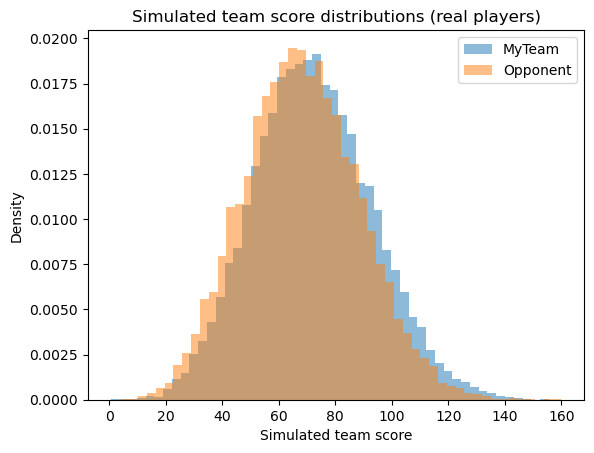

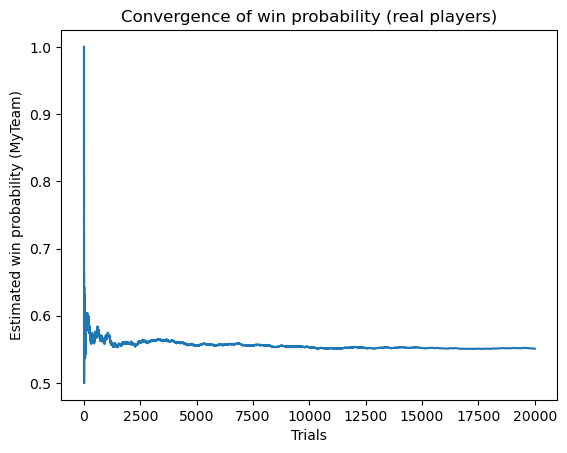

In [57]:
# Histogram
plt.figure()
plt.hist(A_scores, bins=50, density=True, alpha=0.5, label='MyTeam')
plt.hist(B_scores, bins=50, density=True, alpha=0.5, label='Opponent')
plt.xlabel('Simulated team score')
plt.ylabel('Density')
plt.title('Simulated team score distributions (real players)')
plt.legend()
plt.show()

# Convergence of estimated win probability
est, wins = [], 0
for i in range(N_TRIALS):
    if A_scores[i] > B_scores[i]:
        wins += 1
    est.append(wins / (i+1))

plt.figure()
plt.plot(np.arange(1, N_TRIALS+1), est)
plt.xlabel('Trials')
plt.ylabel('Estimated win probability (MyTeam)')
plt.title('Convergence of win probability (real players)')
plt.show()